In [75]:
import numpy as np
from astropy.io import fits
from astropy.nddata import Cutout2D
import matplotlib.pyplot as plt
from lbcred.model import imfit
import pymfit, os
from collections import OrderedDict
from astropy.table import Table
import pandas

def make_cutout(original_img_fn, position, shape, ext = 0, cutout_fn=None):
    img = fits.open(original_img_fn)
    cutout = Cutout2D(img[ext].data, position, shape)
    
    # Check cutout shape
    # vstack if necessary
    if cutout.data.shape[0] != shape[0]:
        zeros = np.zeros((shape[0]-cutout.data.shape[0],cutout.data.shape[1]))
        cutout.data = np.vstack((cutout.data,zeros))
        
    # hstack if necessary
    if cutout.data.shape[1] != shape[1]:
        zeros = np.zeros((cutout.data.shape[0],shape[1]-cutout.data.shape[1]))
        cutout.data = np.hstack((zeros,cutout.data))
    
    img[ext].data = cutout.data
    if cutout_fn is not None:
        img.writeto(cutout_fn, overwrite=True)
    img.close()
    return cutout

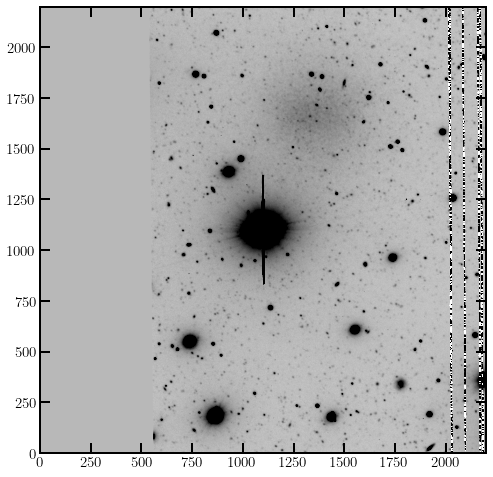

In [30]:
out_dir = '/Users/kirstencasey/real_image_tests/star_subtraction_tests/jupyter_notebook_results'
stack_fn_r = os.path.join(out_dir,'mean_stack_polynomial_background_r.fits')
stack_fn_b = os.path.join(out_dir,'mean_stack_polynomial_background_b.fits')

star_r = make_cutout(stack_fn_r,(1271,2198),(2201,2201),cutout_fn=stack_fn_r.replace('_r.fits','_cutout_r.fits'))
star_b = make_cutout(stack_fn_b,(1271,2198),(2201,2201),cutout_fn=stack_fn_b.replace('_b.fits','_cutout_b.fits'))
var = fits.PrimaryHDU(np.zeros((2201,2201))+1)
var.writeto(os.path.join(out_dir,'flat_variance_image.fits'),overwrite=True)

vmin,vmax =  np.nanpercentile(star_b.data, [.5, 98.])
plt.figure(figsize=(8,10))
plt.imshow(star_b.data,vmin=vmin,vmax=vmax,cmap='gray_r',origin='lower')

## b-band

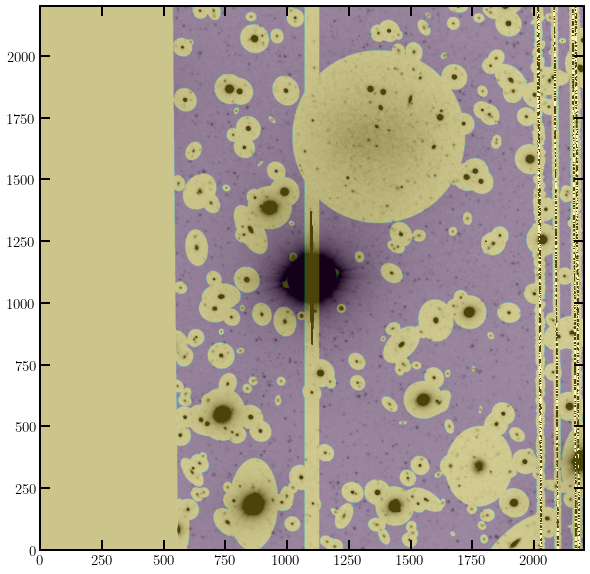

In [8]:
# Make mask for everything except star

mask_kws = dict(out_fn=os.path.join(out_dir,'star_mask_b.fits'), thresh=8.0, kern_sig=1.0, backsize=15,
                        obj_rmin=200, grow_obj=15., use_hsc_mask=False, gal_pos=(1100,1100), seg_rmin=0.)
saturation_limit = 40000.
mask = pymfit.make_mask(stack_fn_b.replace('_b.fits','_cutout_b.fits'), **mask_kws)
mask[np.where(star_b.data==0.)]=1

# Mask Blobby
r_circ = 350
i_c, j_c = (1672, 1370)
ii, jj = np.mgrid[:mask.shape[0], :mask.shape[1]]
circ_mask = ((ii - i_c)**2 + (jj - j_c)**2) - r_circ**2 < 0
mask = mask.astype(bool) | circ_mask
mask = mask.astype(float)
# Mask other stuff
r_circ = 60
i_c, j_c = (832, 539)
ii, jj = np.mgrid[:mask.shape[0], :mask.shape[1]]
circ_mask = ((ii - i_c)**2 + (jj - j_c)**2) - r_circ**2 < 0
mask = mask.astype(bool) | circ_mask
mask = mask.astype(float)

# Anti-mask star

r_circ = 100
i_c, j_c = (1100, 1100)
ii, jj = np.mgrid[:mask.shape[0], :mask.shape[1]]
star_mask = ((ii - i_c)**2 + (jj - j_c)**2) - r_circ**2 < 0
mask[star_mask] = 0


mask[0:2201,1070:1130]=1
mask[np.where(star_b.data>saturation_limit)]=1

plt.figure(figsize=(12,10))
plt.imshow(star_b.data,vmin=vmin,vmax=vmax,cmap='gray_r',origin='lower')
plt.imshow(mask,origin='lower',alpha=0.3)

mask_hdu = fits.PrimaryHDU(mask)
mask_hdu.writeto(os.path.join(out_dir,'star_mask_b.fits'),overwrite=True)

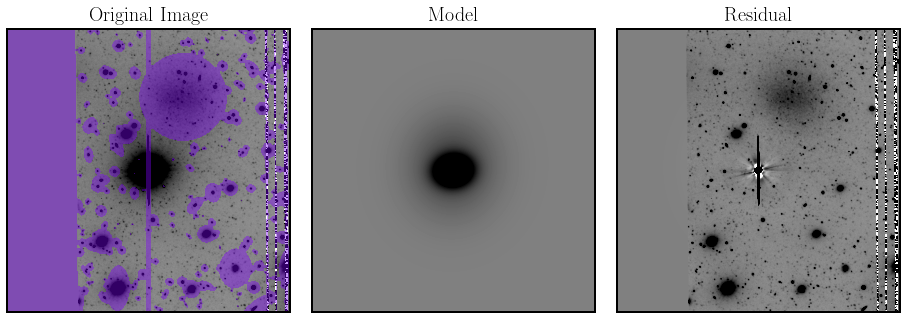

OrderedDict([('comp_1',
              {'function': 'Gaussian',
               'X0': 1092.114,
               'Y0': 1140.0,
               'X0_err': 0.0263,
               'Y0_err': 0.0,
               'PA': 265.155,
               'PA_err': 0.044484,
               'ell': -0.10818,
               'ell_err': 0.00017466,
               'I_0': 42.0911,
               'I_0_err': 0.01148,
               'sigma': 233.781,
               'sigma_err': 0.030887}),
             ('comp_2',
              {'function': 'Gaussian',
               'X0': 1098.3213,
               'Y0': 1097.4228,
               'X0_err': 0.0009,
               'Y0_err': 0.0032,
               'PA': 7.97726,
               'PA_err': 0.0073816,
               'ell': 0.297805,
               'ell_err': 0.00011427,
               'I_0': 7544.41,
               'I_0_err': 3.005,
               'sigma': 21.096,
               'sigma_err': 0.002717}),
             ('comp_3',
              {'function': 'Gaussian',
            

In [10]:
gauss_params = OrderedDict([
    ('PA', [20., 0., 360]),
    ('ell', [0.05, -1., 1.]),
    ('I_0', [500, 0, 15000]),
    ('sigma', [100, 0.1, 1000])
])

out_dir = '/Users/kirstencasey/real_image_tests/star_subtraction_tests'
stack_fn_b = os.path.join(out_dir,'mean_stack_polynomial_background_b.fits')

model = pymfit.Model(funcs = ['Gaussian','Gaussian','Gaussian','Gaussian','Gaussian'], params = [gauss_params,gauss_params,gauss_params,gauss_params,gauss_params], centers = [[1100,1100],[1100,1100],[1100,1100],[1100,1100],[1100,1100]], dcent=40)
fitter = pymfit.PymFitter(model,save_files=True)
bestfit_fn = os.path.join(out_dir,'star_bestfit_b.txt')
config_fn = os.path.join(out_dir,'star_config_b.txt')
fitter.run(stack_fn_b.replace('_b.fits','_cutout_b.fits'), var_fn=os.path.join(out_dir,'flat_variance_image.fits'), mask_fn=os.path.join(out_dir,'star_mask_b.fits'), psf_fn=os.path.join(out_dir,'lbcb.median_psf_298.fits'), out_fn=bestfit_fn, outdir=out_dir, config_fn=config_fn, save_model=True, save_residual=True, will_viz=True)
fitter.viz_results(show=True, save_fn=os.path.join(out_dir,'star_modeling_results.png'), dpi=200);
fitter.results

## r-band

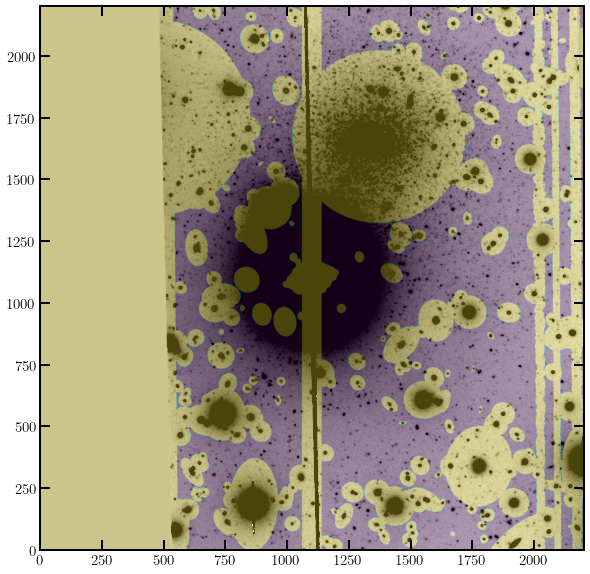

In [31]:
# Make mask for everything except star

mask_kws = dict(out_fn=os.path.join(out_dir,'star_mask_r.fits'), thresh=8.0, kern_sig=1.0, backsize=15,
                        obj_rmin=200, grow_obj=15., use_hsc_mask=False, gal_pos=(1100,1100), seg_rmin=0.)
saturation_limit = 40000.
mask = pymfit.make_mask(stack_fn_b.replace('_b.fits','_cutout_b.fits'), **mask_kws)
mask[np.where(star_b.data==0.)]=1

# Mask Blobby
r_circ = 350
i_c, j_c = (1672, 1370)
ii, jj = np.mgrid[:mask.shape[0], :mask.shape[1]]
circ_mask = ((ii - i_c)**2 + (jj - j_c)**2) - r_circ**2 < 0
mask = mask.astype(bool) | circ_mask
mask = mask.astype(float)
# Mask other stuff
r_circ = 60
i_c, j_c = (832, 539)
ii, jj = np.mgrid[:mask.shape[0], :mask.shape[1]]
circ_mask = ((ii - i_c)**2 + (jj - j_c)**2) - r_circ**2 < 0
mask = mask.astype(bool) | circ_mask
mask = mask.astype(float)
r_circ = 400
i_c, j_c = (1750, 450)
ii, jj = np.mgrid[:mask.shape[0], :mask.shape[1]]
circ_mask = ((ii - i_c)**2 + (jj - j_c)**2) - r_circ**2 < 0
mask = mask.astype(bool) | circ_mask
mask = mask.astype(float)

# Anti-mask star
'''
r_circ = 100
i_c, j_c = (1100, 1100)
ii, jj = np.mgrid[:mask.shape[0], :mask.shape[1]]
star_mask = ((ii - i_c)**2 + (jj - j_c)**2) - r_circ**2 < 0
mask[star_mask] = 0
'''

mask[0:2201,1060:1140]=1
mask[np.where(star_r.data>saturation_limit)]=1

plt.figure(figsize=(12,10))
plt.imshow(star_r.data,vmin=vmin,vmax=vmax,cmap='gray_r',origin='lower')
plt.imshow(mask,origin='lower',alpha=0.3)

In [32]:
mask_hdu = fits.PrimaryHDU(mask)
mask_hdu.writeto(os.path.join(out_dir,'star_mask.fits'),overwrite=True)

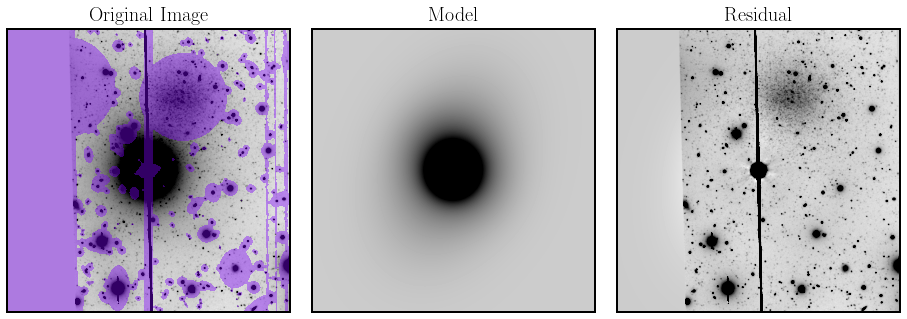

OrderedDict([('comp_1',
              {'function': 'Gaussian',
               'X0': 1060.0,
               'Y0': 1140.0,
               'X0_err': 0.0,
               'Y0_err': 0.0,
               'PA': 68.0917,
               'PA_err': 0.0045244,
               'ell': -0.444904,
               'ell_err': 0.00014501,
               'I_0': 129.585,
               'I_0_err': 0.031773,
               'sigma': 304.786,
               'sigma_err': 0.018722}),
             ('comp_2',
              {'function': 'Gaussian',
               'X0': 1098.644,
               'Y0': 1099.8119,
               'X0_err': 0.0019,
               'Y0_err': 0.0023,
               'PA': 1.18313,
               'PA_err': 0.010152,
               'ell': 0.0590536,
               'ell_err': 5.7057e-05,
               'I_0': 7498.78,
               'I_0_err': 4.887,
               'sigma': 35.3478,
               'sigma_err': 0.0080713}),
             ('comp_3',
              {'function': 'Gaussian',
             

In [34]:
gauss_params = OrderedDict([
    ('PA', [20., 0., 360]),
    ('ell', [0.05, -0.7, 0.7]),
    ('I_0', [10000.0, 0, 10000]),
    ('sigma', [100, 0.1, 1000])
])

out_dir = '/Users/kirstencasey/real_image_tests/star_subtraction_tests/jupyter_notebook_results'
stack_fn_r = os.path.join(out_dir,'mean_stack_polynomial_background_r.fits')

model = pymfit.Model(funcs = ['Gaussian','Gaussian','Gaussian','Gaussian','Gaussian'], params = [gauss_params,gauss_params,gauss_params,gauss_params,gauss_params], centers = [[1100,1100],[1100,1100],[1100,1100],[1100,1100],[1100,1100]], dcent=40)
fitter = pymfit.PymFitter(model,save_files=True)
bestfit_fn = os.path.join(out_dir,'star_bestfit_r.txt')
config_fn = os.path.join(out_dir,'star_config_r.txt')
fitter.run(stack_fn_r.replace('_r.fits','_cutout_r.fits'), var_fn=os.path.join(out_dir,'flat_variance_image.fits'), mask_fn=os.path.join(out_dir,'star_mask.fits'), psf_fn=os.path.join(out_dir,'lbcr.median_psf_298.fits'), out_fn=bestfit_fn, outdir=out_dir, config_fn=config_fn, save_model=True, save_residual=True, will_viz=True)
fitter.viz_results(show=True, save_fn=os.path.join(out_dir,'star_modeling_results.png'), dpi=200);
fitter.results

## Whole image

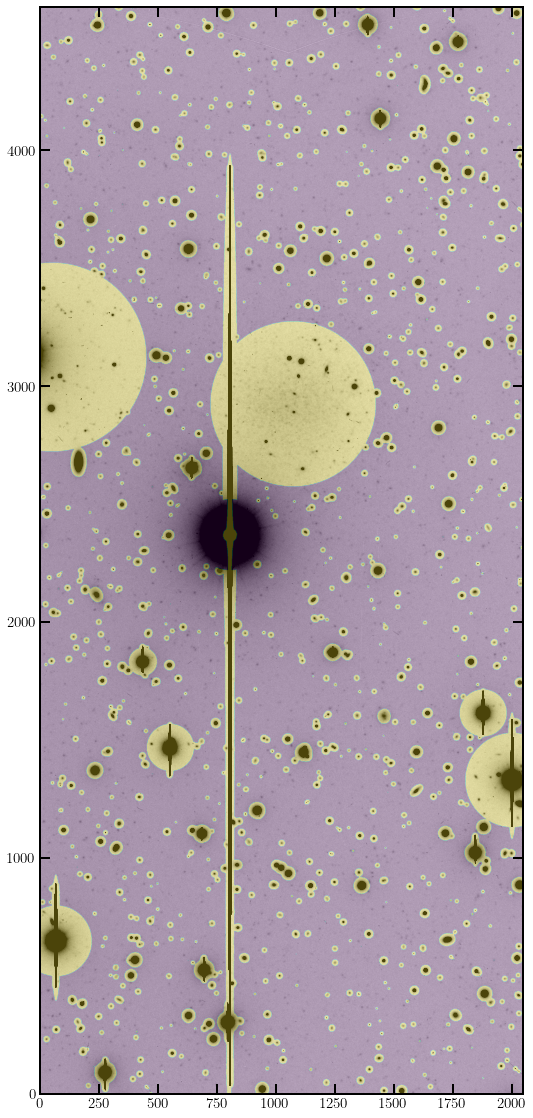

In [36]:
in_dir = '/Users/kirstencasey/real_image_tests/star_subtraction_tests/star_subtracted'
fn_r = os.path.join(in_dir,'lbcr.20191220.071459-chip2_starsub_M81blob.proc.fits')
mask_fn_r = os.path.join(in_dir,'lbcr.20191220.071459-chip2_starsub_mask_M81blob.proc.fits')

mask_r = fits.open(mask_fn_r)[0]
im_r = fits.open(fn_r)[0]

vmin,vmax =  np.nanpercentile(im_r.data, [.5, 98.])
plt.figure(figsize=(18,20))
plt.imshow(im_r.data,vmin=vmin,vmax=vmax,cmap='gray_r',origin='lower')
plt.imshow(mask_r.data,origin='lower',alpha=0.3)

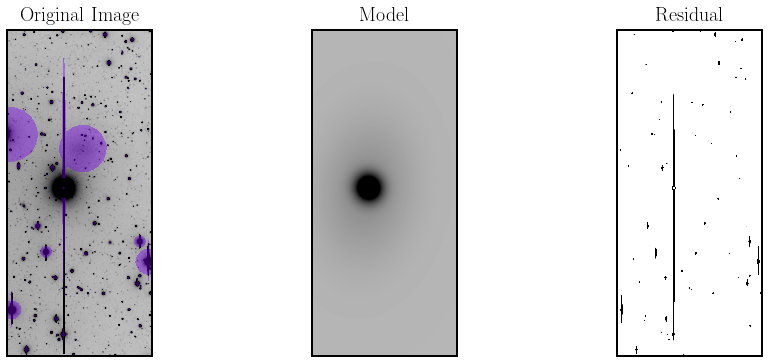

OrderedDict([('comp_1',
              {'function': 'Gaussian',
               'X0': 802.0643,
               'Y0': 2365.9013,
               'X0_err': 0.0017,
               'Y0_err': 0.0007,
               'PA': 86.3153,
               'PA_err': 0.010444,
               'ell': -0.166289,
               'ell_err': 5.436e-05,
               'I_0': 20000.0,
               'I_0_err': 0.0,
               'sigma': 20.0077,
               'sigma_err': 0.00071908}),
             ('comp_2',
              {'function': 'Gaussian',
               'X0': 767.0,
               'Y0': 2339.2051,
               'X0_err': 0.0,
               'Y0_err': 0.0086,
               'PA': 83.1898,
               'PA_err': 0.0011941,
               'ell': -0.5,
               'ell_err': 0.0,
               'I_0': 147.137,
               'I_0_err': 0.0030637,
               'sigma': 449.431,
               'sigma_err': 0.0066548}),
             ('comp_3',
              {'function': 'Gaussian',
               'X0':

In [92]:
gauss_params = OrderedDict([
    ('PA', [20., 0., 360]),
    ('ell', [0.05, -0.5, 0.5]),
    ('I_0', [10000.0, 0, 20000]),
    ('sigma', [25, 0.1, 1000])
])
sky_params = OrderedDict([('I_sky', [8500., 0., 10000])])

model = pymfit.Model(funcs = ['Gaussian','Gaussian','Gaussian','Gaussian','Gaussian','Gaussian','FlatSky'], params = [gauss_params,gauss_params,gauss_params,gauss_params,gauss_params,gauss_params,sky_params], centers = [[807,2370],[807,2370],[807,2370],[807,2370],[807,2370],[807,2370],None], dcent=40)
fitter = pymfit.PymFitter(model,save_files=True)
bestfit_fn = os.path.join(in_dir,'star_bestfit_r.txt')
config_fn = os.path.join(in_dir,'star_config_r.txt')
fitter.run(fn_r, var_fn=os.path.join(in_dir,'flat_variance_image.fits'), mask_fn=mask_fn_r, psf_fn=os.path.join(in_dir,'lbcr.median_psf_298.fits'), out_fn=bestfit_fn, outdir=in_dir, config_fn=config_fn, save_model=True, save_residual=True, will_viz=True)
fitter.viz_results(show=True, save_fn=os.path.join(in_dir,'star_modeling_results.png'), dpi=200);
fitter.results

## Whole image but cutout

(2001, 2001)


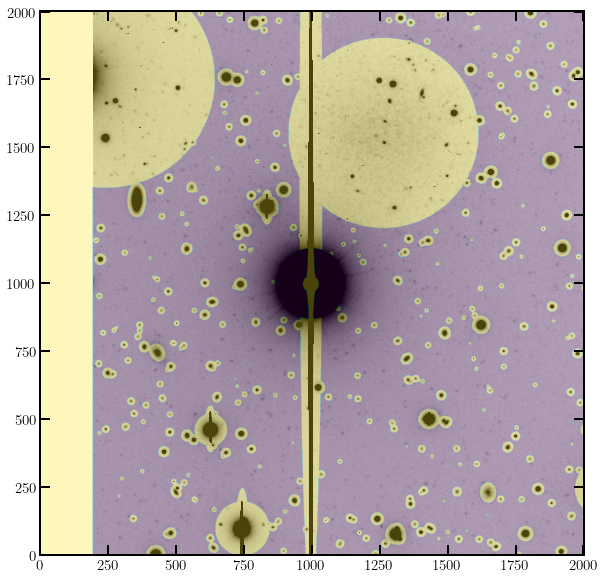

In [87]:
star_r = make_cutout(os.path.join(out_dir,'lbcr.20191220.071459-chip2_starsub_M81blob.proc.fits'),(807,2370),(2001,2001),cutout_fn=os.path.join(out_dir,'lbcr.20191220.071459-chip2_starsub_cutout_M81blob.proc.fits'))
mask_r = make_cutout(os.path.join(in_dir,'lbcr.20191220.071459-chip2_starsub_mask_M81blob.proc.fits'),(807,2370),(2001,2001),cutout_fn=os.path.join(out_dir,'lbcr.20191220.071459-chip2_starsub_mask_cutout_M81blob.proc.fits'))

mask_r.data[np.where(star_r.data==0)] = 1
mask_hdu = fits.PrimaryHDU(mask_r.data)
mask_hdu.writeto(os.path.join(out_dir,'lbcr.20191220.071459-chip2_starsub_mask_cutout_M81blob.proc.fits'),overwrite=True)

plt.figure(figsize=(12,10))
plt.imshow(star_r.data,vmin=vmin,vmax=vmax,cmap='gray_r',origin='lower')
plt.imshow(mask_r.data,origin='lower',alpha=0.3)
print(star_r.data.shape)

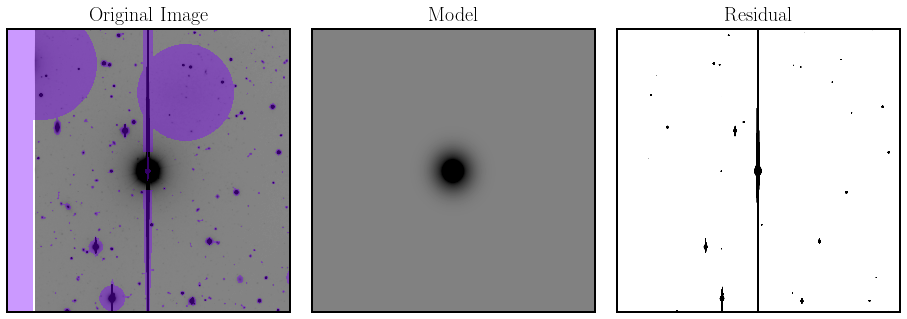

OrderedDict([('comp_1',
              {'function': 'Gaussian',
               'X0': 996.7913,
               'Y0': 997.2989,
               'X0_err': 7.1761,
               'Y0_err': 7.4064,
               'PA': 3.62175,
               'PA_err': 11.974,
               'ell': -0.0677406,
               'ell_err': 0.11513,
               'I_0': 10000.0,
               'I_0_err': 0.0,
               'sigma': 24.8418,
               'sigma_err': 3.8278}),
             ('comp_2',
              {'function': 'Gaussian',
               'X0': 995.7033,
               'Y0': 997.7669,
               'X0_err': 0.0003,
               'Y0_err': 0.0004,
               'PA': 7.43784,
               'PA_err': 0.0026128,
               'ell': 0.0486177,
               'ell_err': 4.9031e-06,
               'I_0': 2859.71,
               'I_0_err': 0.024241,
               'sigma': 98.7977,
               'sigma_err': 0.00046606}),
             ('comp_3',
              {'function': 'Gaussian',
           

In [91]:
gauss_params = OrderedDict([
    ('PA', [20., 0., 360]),
    ('ell', [0.05, -0.5, 0.5]),
    ('I_0', [500.0, 0, 10000]),
    ('sigma', [100, 0.1, 1000])
])
sky_params = OrderedDict([('I_sky', [8500., 0., 10000])])

model = pymfit.Model(funcs = ['Gaussian','Gaussian','Gaussian','Gaussian','Gaussian','FlatSky'], params = [gauss_params,gauss_params,gauss_params,gauss_params,gauss_params,sky_params], centers = [[1000,1000],[1000,1000],[1000,1000],[1000,1000],[1000,1000],None], dcent=40)
fitter = pymfit.PymFitter(model,save_files=True)
bestfit_fn = os.path.join(out_dir,'star_bestfit_r.txt')
config_fn = os.path.join(out_dir,'star_config_r.txt')
var = fits.PrimaryHDU(np.zeros((2001,2001))+1)
var.writeto(os.path.join(out_dir,'flat_variance_image.fits'),overwrite=True)
fitter.run(os.path.join(out_dir,'lbcr.20191220.071459-chip2_starsub_cutout_M81blob.proc.fits'), var_fn=os.path.join(out_dir,'flat_variance_image.fits'), mask_fn=os.path.join(out_dir,'lbcr.20191220.071459-chip2_starsub_mask_cutout_M81blob.proc.fits'), psf_fn=os.path.join(out_dir,'lbcr.median_psf_298.fits'), out_fn=bestfit_fn, outdir=out_dir, config_fn=config_fn, save_model=True, save_residual=True, will_viz=True)
fitter.viz_results(show=True, save_fn=os.path.join(out_dir,'star_modeling_results.png'), dpi=200);
fitter.results

## Old stuff

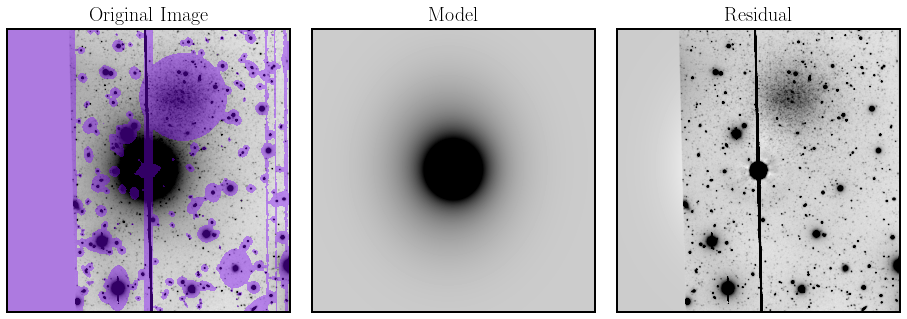

OrderedDict([('comp_1',
              {'function': 'Gaussian',
               'X0': 1060.0,
               'Y0': 1140.0,
               'X0_err': 0.0,
               'Y0_err': 0.0,
               'PA': 1.77636e-15,
               'PA_err': 0.0,
               'ell': 0.172596,
               'ell_err': 2.836e-05,
               'I_0': 154.585,
               'I_0_err': 0.016349,
               'sigma': 407.104,
               'sigma_err': 0.016344}),
             ('comp_2',
              {'function': 'Gaussian',
               'X0': 1099.4878,
               'Y0': 1101.364,
               'X0_err': 0.0007,
               'Y0_err': 0.0008,
               'PA': 0.0,
               'PA_err': 0.0,
               'ell': 0.0300849,
               'ell_err': 1.5743e-05,
               'I_0': 6264.03,
               'I_0_err': 0.476,
               'sigma': 46.7127,
               'sigma_err': 0.0024724}),
             ('comp_3',
              {'function': 'Gaussian',
               'X0': 1107.

In [11]:
gauss_params = OrderedDict([
    ('PA', [20., 0., 360]),
    ('ell', [0.05, -0.7, 0.7]),
    ('I_0', [10000.0, 0, 10000]),
    ('sigma', [100, 0.1, 1000])
])

stack_fn_r = os.path.join(out_dir,'mean_stack_polynomial_background_r.fits')

model = pymfit.Model(funcs = ['Gaussian','Gaussian','Gaussian','Gaussian'], params = [gauss_params,gauss_params,gauss_params,gauss_params], centers = [[1100,1100],[1100,1100],[1100,1100],[1100,1100]], dcent=40)
fitter = pymfit.PymFitter(model,save_files=True)
bestfit_fn = os.path.join(out_dir,'star_bestfit_r.txt')
config_fn = os.path.join(out_dir,'star_config_r.txt')
fitter.run(stack_fn_r.replace('_r.fits','_cutout_r.fits'), var_fn=os.path.join(out_dir,'flat_variance_image.fits'), mask_fn=os.path.join(out_dir,'star_mask.fits'), psf_fn=os.path.join(out_dir,'lbcr.median_psf_298.fits'), out_fn=bestfit_fn, outdir=out_dir, config_fn=config_fn, save_model=True, save_residual=True, will_viz=True)
fitter.viz_results(show=True, save_fn=os.path.join(out_dir,'star_modeling_results_r.png'), dpi=200);
fitter.results

In [ ]:
imfit.run_makeimage(bestfit_fn,)

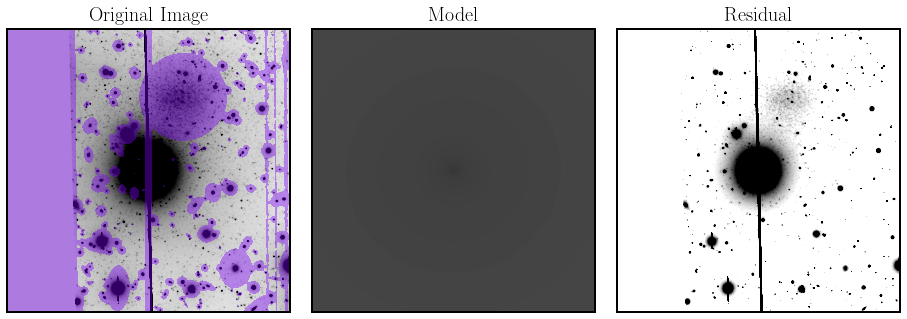

In [87]:
moffat_params = OrderedDict([
    ('PA', [100., 0., 360]),
    ('ell', [0.05, 0., 0.3]),
    ('I_0', [500, 0.01, 10000]),
    ('fwhm', [100, 0.01, 1000]),
    ('beta', [0.01, 0.0, 1.])
])

model = pymfit.Model(funcs = ['Moffat'], params = [moffat_params], centers = [[1100,1100]], dcent=40)
fitter = pymfit.PymFitter(model,save_files=True)
bestfit_fn = os.path.join(out_dir,'star_bestfit_r.txt')
config_fn = os.path.join(out_dir,'star_config_r.txt')

fitter.run(stack_fn_r.replace('_r.fits','_cutout_r.fits'), var_fn=os.path.join(out_dir,'flat_variance_image.fits'), mask_fn=os.path.join(out_dir,'star_mask.fits'), psf_fn=os.path.join(out_dir,'lbcr.median_psf_298.fits'), out_fn=bestfit_fn, outdir=out_dir, config_fn=config_fn, save_model=True, save_residual=True, will_viz=True)

fitter.viz_results(show=True, save_fn=os.path.join(out_dir,'star_modeling_results.png'), dpi=200);

In [76]:
fitter.results

OrderedDict([('comp_1',
              {'function': 'Gaussian',
               'X0': 1100.0,
               'Y0': 1100.0,
               'X0_err': 0.0008,
               'Y0_err': 0.0009,
               'PA': 20.0,
               'PA_err': 0.0069349,
               'ell': 0.05,
               'ell_err': 63511000.0,
               'I_0': 1000.0,
               'I_0_err': 0.0089225,
               'sigma': 100.0,
               'sigma_err': 0.00086521}),
             ('comp_2',
              {'function': 'Gaussian',
               'X0': 1100.0,
               'Y0': 1100.0,
               'X0_err': 0.0,
               'Y0_err': 0.0,
               'PA': 20.0,
               'PA_err': 0.0,
               'ell': 0.05,
               'ell_err': 63511000.0,
               'I_0': 1000.0,
               'I_0_err': 0.0,
               'sigma': 100.0,
               'sigma_err': 0.0}),
             ('comp_3',
              {'function': 'Gaussian',
               'X0': 1100.0,
               'Y0': 

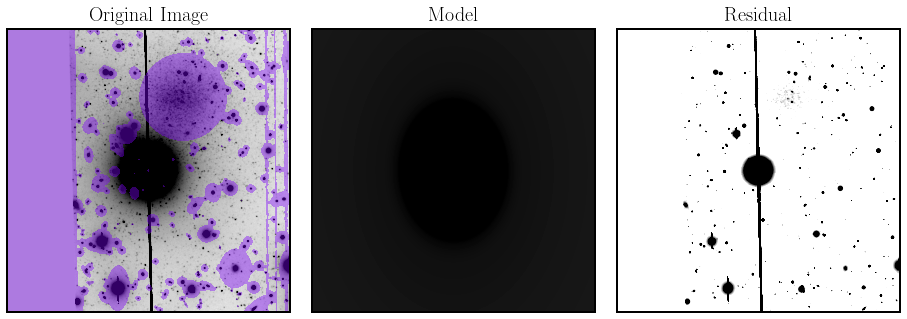

OrderedDict([('comp_1',
              {'function': 'Moffat',
               'X0': 1099.9898,
               'Y0': 1099.9893,
               'X0_err': 0.0324,
               'Y0_err': 0.0522,
               'PA': 6.59407e-09,
               'PA_err': 0.017457,
               'ell': 0.3,
               'ell_err': 0.0,
               'I_0': 589.743,
               'I_0_err': 0.0086764,
               'fwhm': 200.0,
               'fwhm_err': 0.0,
               'beta': 0.0187806,
               'beta_err': 3.1586e-06}),
             ('comp_2',
              {'function': 'Gaussian',
               'X0': 1098.6939,
               'Y0': 1103.782,
               'X0_err': 0.0011,
               'Y0_err': 0.0015,
               'PA': 91.1678,
               'PA_err': 0.001004,
               'ell': -0.3,
               'ell_err': 0.0,
               'I_0': 1000.0,
               'I_0_err': 0.0,
               'sigma': 151.649,
               'sigma_err': 0.00074872}),
             ('reduced_ch

In [74]:
moffat_params = OrderedDict([
    ('PA', [100., 0., 360]),
    ('ell', [0.05, -0.3, 0.3]),
    ('I_0', [500, 0.01, 1000]),
    ('fwhm', [100, 0.01, 200]),
    ('beta', [0.01, 0.0, 1.])
])
gauss_params = OrderedDict([
    ('PA', [100., 0., 360]),
    ('ell', [0.05, -0.3, 0.3]),
    ('I_0', [500.0, 50, 1000]),
    ('sigma', [100, 0.1, 200])
])

model = pymfit.Model(funcs = ['Moffat'], params = [moffat_params], centers = [[1100,1100]], dcent=40)
fitter = pymfit.PymFitter(model,save_files=True)
bestfit_fn = os.path.join(out_dir,'star_bestfit_r.txt')
config_fn = os.path.join(out_dir,'star_config_r.txt')

fitter.run(stack_fn_r.replace('_r.fits','_cutout_r.fits'), var_fn=os.path.join(out_dir,'flat_variance_image.fits'), mask_fn=os.path.join(out_dir,'star_mask.fits'), psf_fn=os.path.join(out_dir,'lbcr.median_psf_298.fits'), out_fn=bestfit_fn, outdir=out_dir, config_fn=config_fn, save_model=True, save_residual=True, will_viz=True)

fitter.viz_results(show=True, save_fn=os.path.join(out_dir,'star_modeling_results.png'), dpi=200);

fitter.results

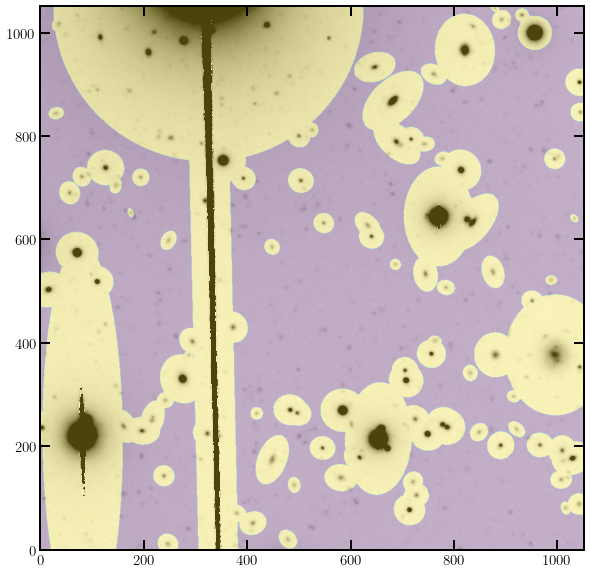

In [37]:
out_dir = '/Users/kirstencasey/real_image_tests/background_subtraction_tests/star_subtraction_tests'


cutout1_r = make_cutout(os.path.join(out_dir,'mean_stack_SEsky_background_r.fits'), (1477,1586), (1051,1051), ext = 0, cutout_fn=os.path.join(out_dir,'mean_stack_polynomial_background_cutout2_r.fits'))
vmin,vmax =  np.nanpercentile(cutout1_r.data, [.5, 98.])

mask_kws = dict(out_fn=os.path.join(out_dir,'cutout2_mask_r.fits'), thresh=12.0, kern_sig=1.0, backsize=15,
                        obj_rmin=200, grow_obj=12., use_hsc_mask=False, gal_pos=(1100,1100), seg_rmin=0.)
saturation_limit = 40000.
mask = pymfit.make_mask(os.path.join(out_dir,'mean_stack_polynomial_background_cutout2_r.fits'), **mask_kws)
mask[np.where(cutout1_r.data==0.)]=1

r_circ = 300
i_c, j_c = (1050,325)
ii, jj = np.mgrid[:mask.shape[0], :mask.shape[1]]
circ_mask = ((ii - i_c)**2 + (jj - j_c)**2) - r_circ**2 < 0
mask = mask.astype(bool) | circ_mask
mask = mask.astype(float)
'''
r_circ = 50
i_c, j_c = (600,0)
ii, jj = np.mgrid[:mask.shape[0], :mask.shape[1]]
circ_mask = ((ii - i_c)**2 + (jj - j_c)**2) - r_circ**2 < 0
mask = mask.astype(bool) | circ_mask
mask = mask.astype(float)

r_circ = 50
i_c, j_c = (995,955)
ii, jj = np.mgrid[:mask.shape[0], :mask.shape[1]]
circ_mask = ((ii - i_c)**2 + (jj - j_c)**2) - r_circ**2 < 0
mask = mask.astype(bool) | circ_mask
mask = mask.astype(float)
'''
plt.figure(figsize=(12,10))
plt.imshow(cutout1_r.data,vmin=vmin,vmax=vmax,cmap='gray_r',origin='lower')
plt.imshow(mask,origin='lower',alpha=0.3)

In [66]:
mask_hdu = fits.PrimaryHDU(mask)
mask_hdu.writeto(os.path.join(out_dir,'cutout1_mask_b.fits'),overwrite=True)

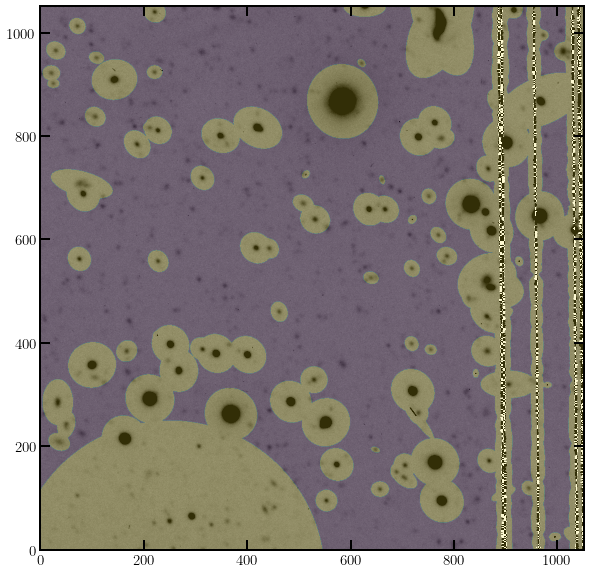

In [65]:
out_dir = '/Users/kirstencasey/real_image_tests/background_subtraction_tests/star_subtraction_tests'


cutout1_r = make_cutout(os.path.join(out_dir,'mean_stack_polynomial_background_b.fits'), (1815,3658), (1051,1051), ext = 0, cutout_fn=os.path.join(out_dir,'mean_stack_SEsky_background_cutout1_b.fits'))
vmin,vmax =  np.nanpercentile(cutout1_r.data, [.9, 98.])

mask_kws = dict(out_fn=os.path.join(out_dir,'cutout1_mask_b.fits'), thresh=8.0, kern_sig=1.0, backsize=15,
                        obj_rmin=200, grow_obj=12., use_hsc_mask=False, gal_pos=(1100,1100), seg_rmin=0.)
saturation_limit = 40000.
mask = pymfit.make_mask(os.path.join(out_dir,'mean_stack_SEsky_background_cutout1_b.fits'), **mask_kws)
mask[np.where(cutout1_r.data==0.)]=1

r_circ = 300
i_c, j_c = (-50,250)
ii, jj = np.mgrid[:mask.shape[0], :mask.shape[1]]
circ_mask = ((ii - i_c)**2 + (jj - j_c)**2) - r_circ**2 < 0
mask = mask.astype(bool) | circ_mask
mask = mask.astype(float)

plt.figure(figsize=(12,10))
plt.imshow(cutout1_r.data,vmin=vmin,vmax=vmax,cmap='gray_r',origin='lower')
plt.imshow(mask,origin='lower',alpha=0.2)

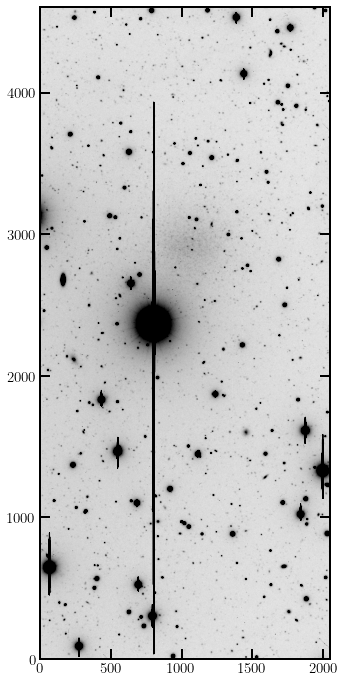

In [4]:
in_dir = '/Users/kirstencasey/real_image_tests/input'
im_r = os.path.join(in_dir,'lbcr.20191220.071459-chip2_M81blob.proc.fits')
im_r = fits.getdata(im_r)
vmin,vmax =  np.nanpercentile(im_r.data, [.5, 98.])
plt.figure(figsize=(12,12))
plt.imshow(im_r.data,vmin=vmin,vmax=vmax,cmap='gray_r',origin='lower')

In [24]:
custom_mask_csv = '/Users/kirstencasey/real_image_tests/star_subtraction_tests/manual_star_subtraction_masks.csv'

custom_mask_details = pandas.read_csv(custom_mask_csv)
custom_mask_details = Table.from_pandas(custom_mask_details)

fn = 'lbcb.20191220.071505-chip2_M81blob.proc.fits'

In [26]:
fn_details = custom_mask_details[np.where(custom_mask_details['filename'] == fn.split('/')[-1])]

In [33]:
for col in fn_details.colnames: print('star' in col)

False
True
True
True
False
False
False
False
False
False
False
False
False


In [32]:
fn_details

<Table length=1>
                  filename                   x_star ... y_other2 radius_other2
                   str44                     int64  ...  int64       int64    
-------------------------------------------- ------ ... -------- -------------
lbcb.20191220.071505-chip2_M81blob.proc.fits    772 ...     1834            60

In [48]:
dic = {'step1' : {'color':'r'},'step2':{'color':'b'}}
for step in dic: 
    print(dic[step])

{'color': 'r'}
{'color': 'b'}


In [46]:
funcs = ['Sersic','Gaussian']
len(funcs)>1 and 'Sersic' in funcs

True

In [52]:
test = np.zeros((5,5)).astype(bool)
test.flatten()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [51]:
True in test.flatten()

False

In [38]:
im_r.data.shape

(4607, 2047)

In [140]:
imfit.run_makeimage(os.path.join(out_dir,'star_bestfit_new_r.txt') , psf_fn=os.path.join(out_dir,'lbcr.median_psf_298.fits'), ref_fn=os.path.join(out_dir,'lbcr.20191220.071459-chip2_starsub_M81blob.proc.fits'), output_root=None, out_fn=os.path.join(out_dir,'test_image.fits'))

In [95]:
fitter.results

OrderedDict([('comp_1',
              {'function': 'Gaussian',
               'X0': 802.0643,
               'Y0': 2365.9013,
               'X0_err': 0.0017,
               'Y0_err': 0.0007,
               'PA': 86.3153,
               'PA_err': 0.010444,
               'ell': -0.166289,
               'ell_err': 5.436e-05,
               'I_0': 20000.0,
               'I_0_err': 0.0,
               'sigma': 20.0077,
               'sigma_err': 0.00071908}),
             ('comp_2',
              {'function': 'Gaussian',
               'X0': 767.0,
               'Y0': 2339.2051,
               'X0_err': 0.0,
               'Y0_err': 0.0086,
               'PA': 83.1898,
               'PA_err': 0.0011941,
               'ell': -0.5,
               'ell_err': 0.0,
               'I_0': 147.137,
               'I_0_err': 0.0030637,
               'sigma': 449.431,
               'sigma_err': 0.0066548}),
             ('comp_3',
              {'function': 'Gaussian',
               'X0':

In [152]:
'''
from os import fdopen, remove

def replace(file_path, pattern, subst):
    #Create temp file
    fh, abs_path = mkstemp()
    with fdopen(fh,'w') as new_file:
        with open(file_path) as old_file:
            for line in old_file:
                new_file.write(line.replace(pattern, subst))
    #Copy the file permissions from the old file to the new file
    copymode(file_path, abs_path)
    #Remove original file
    remove(file_path)
    #Move new file
    move(abs_path, file_path)
'''
x_guess = 805 # these will be the custom mask things
y_guess = 2368
shape=(2001,2001)
new_lines=[]
funcs = []
with open(os.path.join(out_dir,'star_bestfit_r.txt'), 'r') as bf:

    for line in bf.readlines():
        if line[0] == 'X':
            # Get cutout position
            cutout_x = line.split('\t')[2].split(' ')[0]
            # Get new whole image position
            whole_im_x = x_guess - (int(shape[0]/2)-float(cutout_x))
            new_line = line.replace(line.split('\t')[2].split(' ')[0],str(whole_im_x))
            new_lines.append(new_line)

        elif line[0] == 'Y':
            # Get cutout position
            cutout_y = line.split('\t')[2].split(' ')[0]
            # Get new whole image position
            whole_im_y = y_guess - (int(shape[1]/2)-float(cutout_y))
            new_line = line.replace(line.split('\t')[2].split(' ')[0],str(whole_im_y))
            new_lines.append(new_line)
       
        elif line[0] == 'F':
            funcs.append(line.split(' ')[-1].split('\n')[0])
            if 'FlatSky' not in line: new_lines.append(line)
            else: new_lines = new_lines[0:-2]
                
        elif 'sky' not in line: new_lines.append(line)

os.rename(os.path.join(out_dir,'star_bestfit_r.txt'),os.path.join(out_dir,'star_bestfit_r.txt').replace('.txt','_cutoutpositions.txt'))
with open(os.path.join(out_dir,'star_bestfit_r.txt'), 'w') as f:
    f.writelines(new_lines)

In [150]:
imfit.run_makeimage(os.path.join(out_dir,'star_bestfit_new_r.txt') , psf_fn=os.path.join(out_dir,'lbcr.median_psf_298.fits'), ref_fn=os.path.join(out_dir,'lbcr.20191220.071459-chip2_starsub_M81blob.proc.fits'), output_root=None, out_fn=os.path.join(out_dir,'test_image.fits'))

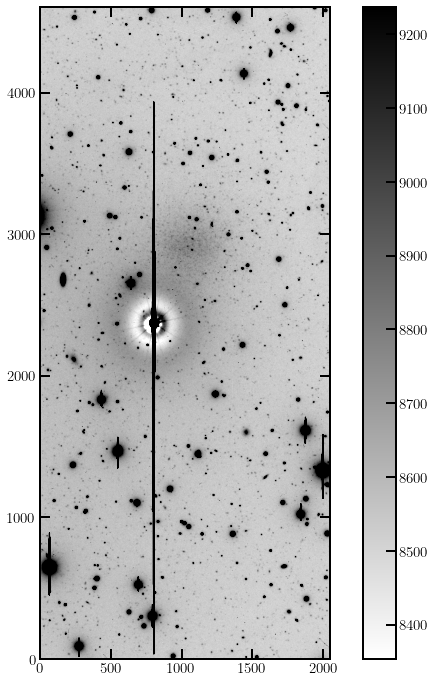

In [151]:
in_dir = '/Users/kirstencasey/real_image_tests/input'
im_r = os.path.join(out_dir,'lbcr.20191220.071459-chip2_starsub_M81blob.proc.fits')
model = os.path.join(out_dir,'test_image.fits')
im_r = fits.getdata(im_r)
model = fits.getdata(model)

res = im_r-model
vmin,vmax =  np.nanpercentile(res, [.5, 98.])
plt.figure(figsize=(12,12))
plt.imshow(res,vmin=vmin,vmax=vmax,cmap='gray_r',origin='lower')
plt.colorbar()

In [154]:
print(fitter.results)

OrderedDict([('comp_1', {'function': 'Gaussian', 'X0': 802.0643, 'Y0': 2365.9013, 'X0_err': 0.0017, 'Y0_err': 0.0007, 'PA': 86.3153, 'PA_err': 0.010444, 'ell': -0.166289, 'ell_err': 5.436e-05, 'I_0': 20000.0, 'I_0_err': 0.0, 'sigma': 20.0077, 'sigma_err': 0.00071908}), ('comp_2', {'function': 'Gaussian', 'X0': 767.0, 'Y0': 2339.2051, 'X0_err': 0.0, 'Y0_err': 0.0086, 'PA': 83.1898, 'PA_err': 0.0011941, 'ell': -0.5, 'ell_err': 0.0, 'I_0': 147.137, 'I_0_err': 0.0030637, 'sigma': 449.431, 'sigma_err': 0.0066548}), ('comp_3', {'function': 'Gaussian', 'X0': 803.3008, 'Y0': 2368.0341, 'X0_err': 0.0009, 'Y0_err': 0.001, 'PA': 54.0731, 'PA_err': 0.0069369, 'ell': 0.172313, 'ell_err': 3.0276e-05, 'I_0': 20000.0, 'I_0_err': 0.0, 'sigma': 22.2943, 'sigma_err': 0.00070211}), ('comp_4', {'function': 'Gaussian', 'X0': 803.7198, 'Y0': 2367.1507, 'X0_err': 0.0002, 'Y0_err': 0.0002, 'PA': 6.22777, 'PA_err': 0.0031838, 'ell': 0.0388816, 'ell_err': 4.5664e-06, 'I_0': 6654.89, 'I_0_err': 0.11997, 'sigma': 